In [1]:
import xarray
import numpy as np
from natsort import natsorted
import xarray as xr

import matplotlib.pyplot as plt
import sunpy.visualization.colormaps as cm
from codecarbon import track_emissions
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

The following packages are not installed:
['mpl-animators>=1.0.0']
To install sunpy with these dependencies use `pip install sunpy[visualization]` or `pip install sunpy[all]` for all extras. 
If you installed sunpy via conda, please report this to the community channel: https://matrix.to/#/#sunpy:openastronomy.org [sunpy.util.sysinfo]


device(type='cuda')

In [2]:
ds = xr.open_dataset("./all128.nc")
print(f"{ds.channel=}")

selected_channel = ds['DN'].sel(channel='171A')
print(f"{selected_channel=}")

TIME_MAX = 6129


ds.channel=<xarray.DataArray 'channel' (channel: 9)> Size: 72B
array(['131A', '1600A', '1700A', '171A', '193A', '211A', '304A', '335A', '94A'],
      dtype=object)
Coordinates:
  * channel  (channel) object 72B '131A' '1600A' '1700A' ... '304A' '335A' '94A'
selected_channel=<xarray.DataArray 'DN' (time: 6130, x: 128, y: 128)> Size: 402MB
[100433920 values with dtype=float32]
Coordinates:
  * time     (time) int32 25kB 0 1 2 3 4 5 6 ... 6124 6125 6126 6127 6128 6129
  * x        (x) int32 512B 0 1 2 3 4 5 6 7 ... 120 121 122 123 124 125 126 127
  * y        (y) int32 512B 0 1 2 3 4 5 6 7 ... 120 121 122 123 124 125 126 127
    channel  <U4 16B '171A'


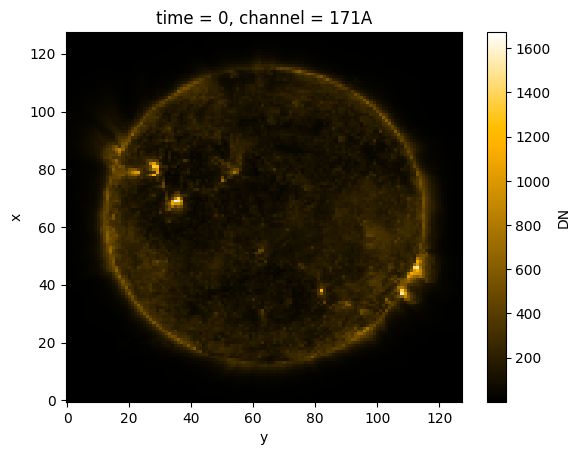

<Figure size 640x480 with 0 Axes>

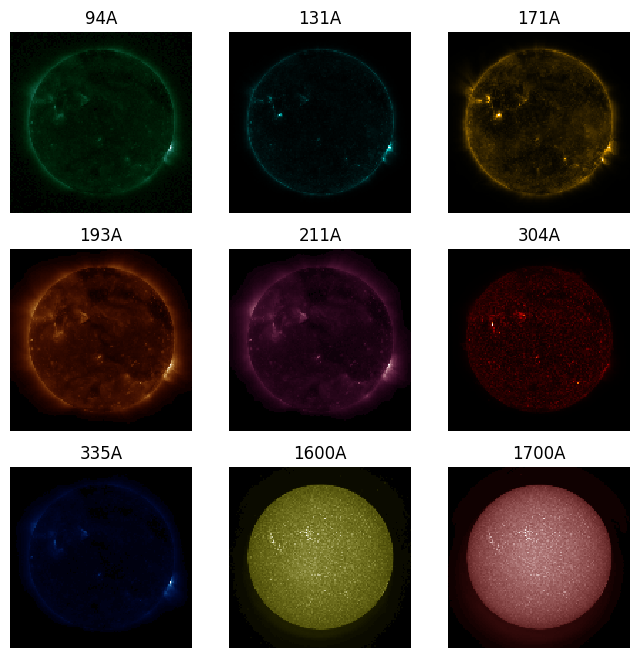

<Figure size 640x480 with 0 Axes>

In [3]:
img = selected_channel.isel(time=0)
cmap = plt.get_cmap('sdoaia171')
img.plot(cmap=cmap)
plt.show()
plt.savefig("single.png")

keys = natsorted(ds['channel'].data)
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for ax, key in zip(axes.ravel(), keys):
    data = ds['DN'].sel(channel=key).isel(time=0)
    cmap = plt.get_cmap(f'sdoaia{key[:-1]}')
    im = data.plot(cmap=cmap, ax=ax, add_colorbar=False)
    ax.set_title(key)
    ax.axis('off')

plt.show()
plt.savefig("multiple.png")

In [12]:
import torch.nn.functional as F
from torch import nn
from torchsummary import summary

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=21, stride=1, padding=10)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=21, stride=1, padding=10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

model = CNN()
model.to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 1, 128, 128]             442
            Conv2d-2          [-1, 1, 128, 128]             442
Total params: 884
Trainable params: 884
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.25
Params size (MB): 0.00
Estimated Total Size (MB): 0.32
----------------------------------------------------------------


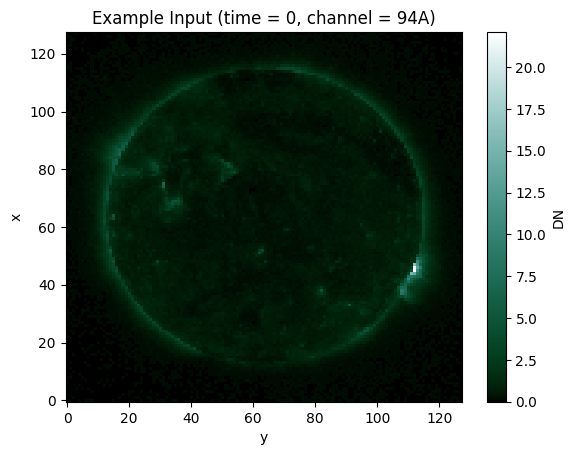

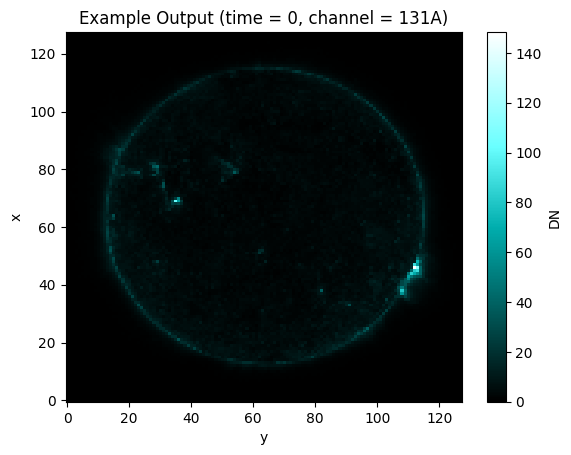

2.505171298980713
[[0.12568463 0.1519866  0.08732574 ... 0.03439286 0.09171439 0.03418508]
 [0.08315779 0.06789741 0.15949668 ... 0.0526607  0.05002134 0.06198227]
 [0.15365343 0.06194307 0.09577445 ... 0.02292858 0.04585719 0.03225015]
 ...
 [0.11005676 0.11858688 0.113459   ... 0.02292819 0.07344869 0.11427572]
 [0.11086306 0.13254918 0.16819568 ... 0.16568273 0.11916012 0.07966339]
 [0.11355234 0.0748238  0.10023839 ... 0.10251278 0.01719645 0.11088042]] 148.35023


In [13]:
input_channel = ds['DN'].sel(channel='94A')
output_channel = ds['DN'].sel(channel='131A')

img = input_channel.isel(time=0)
plt.clf()
cmap = plt.get_cmap('sdoaia94')
img.plot(cmap=cmap)
plt.title("Example Input (time = 0, channel = 94A)")
plt.show()

# print(img[100, 60].item())
# print(img.to_numpy(), np.max(img.to_numpy()))

img = output_channel.isel(time=0)
plt.clf()
cmap = plt.get_cmap('sdoaia131')
img.plot(cmap=cmap)
plt.title("Example Output (time = 0, channel = 131A)")
plt.show()

print(img[100, 60].item())
print(img.to_numpy(), np.max(img.to_numpy()))

In [32]:
input_data = []
for i in range(int(TIME_MAX)):
    input_data.append(input_channel.isel(time=i).to_numpy())

input_data = np.array(input_data)
input_data = torch.from_numpy(input_data)
input_data = input_data.unsqueeze(1)
print(input_data.shape)

output_data = []
for i in range(int(TIME_MAX)):
    output_data.append(output_channel.isel(time=i).to_numpy())

output_data = np.array(output_data)
output_data = torch.from_numpy(output_data)
output_data = output_data.unsqueeze(1)
print(input_data.shape)

X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

torch.Size([6129, 1, 128, 128])
torch.Size([6129, 1, 128, 128])


In [33]:
# loss function for comparing images
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

<Figure size 640x480 with 0 Axes>

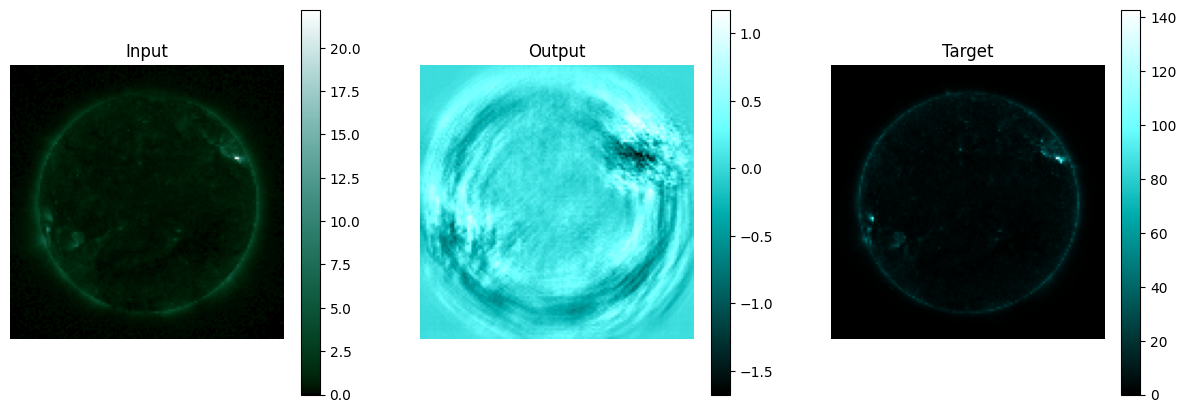

In [34]:
test_index = 0
input_cmap = plt.get_cmap('sdoaia94')
output_cmap = plt.get_cmap('sdoaia131')
# before training
Y_test_prediction = model(X_test[test_index].to(device)).cpu().detach().numpy()

plt.clf()
# make 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot input image
im0 = axes[0].imshow(X_test[test_index].cpu().detach().numpy()[0], cmap=input_cmap)
axes[0].set_title('Input')
axes[0].axis('off')
fig.colorbar(im0, ax=axes[0])

# plot output image
im1 = axes[1].imshow(Y_test_prediction[0], cmap=output_cmap)
axes[1].set_title('Output')
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1])

# plot target image
im2 = axes[2].imshow(y_test[test_index][0], cmap=output_cmap)
axes[2].set_title('Target')
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2])

plt.show()

In [35]:
# put tensors on cuda
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([4903, 1, 128, 128]) torch.Size([4903, 1, 128, 128]) torch.Size([1226, 1, 128, 128]) torch.Size([1226, 1, 128, 128])


In [37]:

def train(num_epochs, model, X_train, y_train, X_test, y_test):

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        
        train_prediction = model(X_train)
        loss = loss_func(train_prediction, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # validation
        model.eval()
        with torch.no_grad():
            test_prediction = model(X_test)
            loss = loss_func(test_prediction, y_test)
            val_losses.append(loss.item())

        print(f"Epoch: {epoch+1}/{num_epochs} | loss: {train_losses[-1]} | val_loss: {val_losses[-1]}")
    return train_losses, val_losses

num_epochs = 50
train_losses, val_losses = train(num_epochs, model, X_train, y_train, X_test, y_test)

  2%|▏         | 1/50 [00:05<04:30,  5.51s/it]

Epoch: 1/50 | loss: 41.66011428833008 | val_loss: 39.16112518310547


  4%|▍         | 2/50 [00:10<04:16,  5.35s/it]

Epoch: 2/50 | loss: 38.28793716430664 | val_loss: 34.56871795654297


  6%|▌         | 3/50 [00:16<04:11,  5.35s/it]

Epoch: 3/50 | loss: 34.106285095214844 | val_loss: 29.689313888549805


  8%|▊         | 4/50 [00:21<04:04,  5.32s/it]

Epoch: 4/50 | loss: 30.332176208496094 | val_loss: 25.961997985839844


 10%|█         | 5/50 [00:26<03:59,  5.32s/it]

Epoch: 5/50 | loss: 28.87881851196289 | val_loss: 24.78691291809082


 12%|█▏        | 6/50 [00:31<03:53,  5.31s/it]

Epoch: 6/50 | loss: 30.679845809936523 | val_loss: 24.73474884033203


 14%|█▍        | 7/50 [00:37<03:46,  5.27s/it]

Epoch: 7/50 | loss: 31.9782657623291 | val_loss: 24.37555503845215


 16%|█▌        | 8/50 [00:42<03:41,  5.28s/it]

Epoch: 8/50 | loss: 31.09029197692871 | val_loss: 24.096038818359375


 18%|█▊        | 9/50 [00:47<03:36,  5.28s/it]

Epoch: 9/50 | loss: 29.357812881469727 | val_loss: 24.398902893066406


 20%|██        | 10/50 [00:53<03:31,  5.28s/it]

Epoch: 10/50 | loss: 28.072519302368164 | val_loss: 25.29206657409668


 22%|██▏       | 11/50 [00:58<03:26,  5.29s/it]

Epoch: 11/50 | loss: 27.666378021240234 | val_loss: 26.408903121948242


 24%|██▍       | 12/50 [01:03<03:20,  5.28s/it]

Epoch: 12/50 | loss: 27.894729614257812 | val_loss: 27.34184455871582


 26%|██▌       | 13/50 [01:08<03:15,  5.28s/it]

Epoch: 13/50 | loss: 28.3026180267334 | val_loss: 27.84819221496582


 28%|██▊       | 14/50 [01:14<03:09,  5.27s/it]

Epoch: 14/50 | loss: 28.556476593017578 | val_loss: 27.859071731567383


 30%|███       | 15/50 [01:19<03:04,  5.27s/it]

Epoch: 15/50 | loss: 28.518213272094727 | val_loss: 27.41701889038086


 32%|███▏      | 16/50 [01:24<02:59,  5.27s/it]

Epoch: 16/50 | loss: 28.19603729248047 | val_loss: 26.63045883178711


 34%|███▍      | 17/50 [01:29<02:53,  5.26s/it]

Epoch: 17/50 | loss: 27.690269470214844 | val_loss: 25.652978897094727


 36%|███▌      | 18/50 [01:35<02:48,  5.27s/it]

Epoch: 18/50 | loss: 27.156352996826172 | val_loss: 24.66449737548828


 38%|███▊      | 19/50 [01:40<02:43,  5.27s/it]

Epoch: 19/50 | loss: 26.763376235961914 | val_loss: 23.832918167114258


 40%|████      | 20/50 [01:45<02:38,  5.27s/it]

Epoch: 20/50 | loss: 26.627033233642578 | val_loss: 23.256624221801758


 42%|████▏     | 21/50 [01:51<02:32,  5.27s/it]

Epoch: 21/50 | loss: 26.73032569885254 | val_loss: 22.928239822387695


 44%|████▍     | 22/50 [01:56<02:27,  5.28s/it]

Epoch: 22/50 | loss: 26.904050827026367 | val_loss: 22.773082733154297


 46%|████▌     | 23/50 [02:01<02:22,  5.28s/it]

Epoch: 23/50 | loss: 26.93746566772461 | val_loss: 22.737335205078125


 48%|████▊     | 24/50 [02:06<02:16,  5.27s/it]

Epoch: 24/50 | loss: 26.744598388671875 | val_loss: 22.825260162353516


 50%|█████     | 25/50 [02:12<02:11,  5.27s/it]

Epoch: 25/50 | loss: 26.411718368530273 | val_loss: 23.054401397705078


 52%|█████▏    | 26/50 [02:17<02:05,  5.25s/it]

Epoch: 26/50 | loss: 26.095726013183594 | val_loss: 23.397418975830078


 54%|█████▍    | 27/50 [02:22<02:00,  5.26s/it]

Epoch: 27/50 | loss: 25.899694442749023 | val_loss: 23.771121978759766


 56%|█████▌    | 28/50 [02:27<01:55,  5.24s/it]

Epoch: 28/50 | loss: 25.82596778869629 | val_loss: 24.0703067779541


 58%|█████▊    | 29/50 [02:33<01:49,  5.23s/it]

Epoch: 29/50 | loss: 25.80760383605957 | val_loss: 24.209928512573242


 60%|██████    | 30/50 [02:38<01:44,  5.24s/it]

Epoch: 30/50 | loss: 25.76618194580078 | val_loss: 24.14935874938965


 62%|██████▏   | 31/50 [02:43<01:39,  5.23s/it]

Epoch: 31/50 | loss: 25.653011322021484 | val_loss: 23.895910263061523


 64%|██████▍   | 32/50 [02:48<01:34,  5.24s/it]

Epoch: 32/50 | loss: 25.46267318725586 | val_loss: 23.496021270751953


 66%|██████▌   | 33/50 [02:53<01:28,  5.23s/it]

Epoch: 33/50 | loss: 25.226232528686523 | val_loss: 23.02032470703125


 68%|██████▊   | 34/50 [02:59<01:23,  5.24s/it]

Epoch: 34/50 | loss: 24.992658615112305 | val_loss: 22.544878005981445


 70%|███████   | 35/50 [03:04<01:18,  5.26s/it]

Epoch: 35/50 | loss: 24.80436134338379 | val_loss: 22.131488800048828


 72%|███████▏  | 36/50 [03:09<01:13,  5.24s/it]

Epoch: 36/50 | loss: 24.67477798461914 | val_loss: 21.81431007385254


 74%|███████▍  | 37/50 [03:14<01:08,  5.24s/it]

Epoch: 37/50 | loss: 24.58078384399414 | val_loss: 21.600339889526367


 76%|███████▌  | 38/50 [03:20<01:02,  5.24s/it]

Epoch: 38/50 | loss: 24.479211807250977 | val_loss: 21.482166290283203


 78%|███████▊  | 39/50 [03:25<00:57,  5.24s/it]

Epoch: 39/50 | loss: 24.33875274658203 | val_loss: 21.44999885559082


 80%|████████  | 40/50 [03:30<00:52,  5.24s/it]

Epoch: 40/50 | loss: 24.161502838134766 | val_loss: 21.49227523803711


 82%|████████▏ | 41/50 [03:35<00:47,  5.24s/it]

Epoch: 41/50 | loss: 23.976608276367188 | val_loss: 21.58836555480957


 84%|████████▍ | 42/50 [03:41<00:41,  5.24s/it]

Epoch: 42/50 | loss: 23.815401077270508 | val_loss: 21.705121994018555


 86%|████████▌ | 43/50 [03:46<00:36,  5.25s/it]

Epoch: 43/50 | loss: 23.690967559814453 | val_loss: 21.802961349487305


 88%|████████▊ | 44/50 [03:51<00:31,  5.25s/it]

Epoch: 44/50 | loss: 23.59528923034668 | val_loss: 21.847457885742188


 90%|█████████ | 45/50 [03:56<00:26,  5.26s/it]

Epoch: 45/50 | loss: 23.510032653808594 | val_loss: 21.819225311279297


 92%|█████████▏| 46/50 [04:02<00:21,  5.26s/it]

Epoch: 46/50 | loss: 23.419822692871094 | val_loss: 21.717790603637695


 94%|█████████▍| 47/50 [04:07<00:15,  5.27s/it]

Epoch: 47/50 | loss: 23.31992530822754 | val_loss: 21.559362411499023


 96%|█████████▌| 48/50 [04:12<00:10,  5.25s/it]

Epoch: 48/50 | loss: 23.21628761291504 | val_loss: 21.370431900024414


 98%|█████████▊| 49/50 [04:17<00:05,  5.25s/it]

Epoch: 49/50 | loss: 23.119901657104492 | val_loss: 21.179643630981445


100%|██████████| 50/50 [04:23<00:00,  5.26s/it]

Epoch: 50/50 | loss: 23.039121627807617 | val_loss: 21.0104923248291


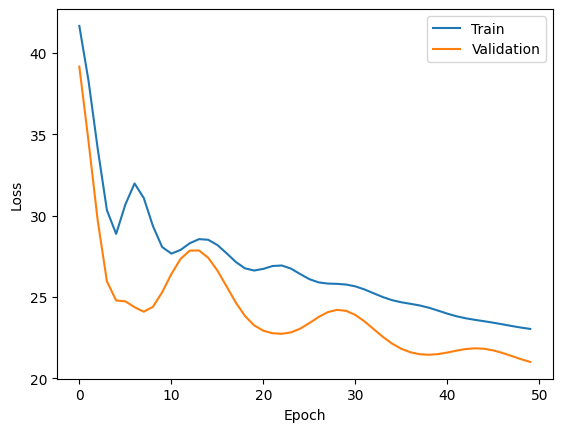

In [38]:
plt.clf()
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

<Figure size 640x480 with 0 Axes>

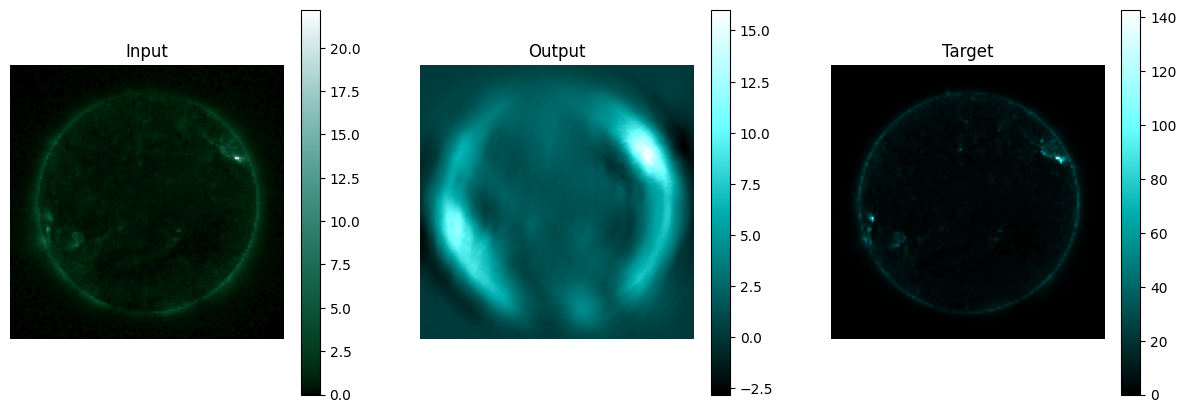

In [40]:
test_index = 0
input_cmap = plt.get_cmap('sdoaia94')
output_cmap = plt.get_cmap('sdoaia131')
# before training
Y_test_prediction = model(X_test[test_index].to(device)).cpu().detach().numpy()

plt.clf()
# make 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot input image
im0 = axes[0].imshow(X_test[test_index].cpu().detach().numpy()[0], cmap=input_cmap)
axes[0].set_title('Input')
axes[0].axis('off')
fig.colorbar(im0, ax=axes[0])

# plot output image
im1 = axes[1].imshow(Y_test_prediction[0], cmap=output_cmap)
axes[1].set_title('Output')
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1])

# plot target image
im2 = axes[2].imshow(y_test[test_index][0].cpu().detach().numpy(), cmap=output_cmap)
axes[2].set_title('Target')
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2])